# Lab 1 - K-Nearest Neighbours

This lab is about the implementation and analysis of the KNN algorithm for classification problems

In [49]:
# Packages used
# Andres        Coronado    2761046
# Garbarino     Giacomo     4545532
%matplotlib notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.interpolate import griddata
import os
import pickle
np.random.seed(100)

### Assignment 0: Data generation for binary classification

We start generating a training set for binary classification problems. Consider the following function, that generates random 2D points on the plane and assigns them a binary label according to their position w.r.t. a linear separator.

Implement a function `linearBinaryClass` which given a sample size `n`, lower and upper bounds `low_D, high_D` for the domain of the samples and the linear function parameters `m, q`, generates a binary classification dataset i.e. it returns `X` and `Y`.

The signature of the function is the following:

`X, Y = linearBinaryClass(n, low_D, high_D, m, q)`

where
- **n** is the number of samples to be generated
- **low_D** and **high_D** are, respectively, the lower and upper bounds for the domain of the samples i.e.
    $$
    X_{i,j} \sim \mathcal{U}(\text{low_D}, \text{high_D})
    $$
- **m, q** are the linear function parameters
- **X**, **Y**: 2-dimensional samples (X) associated with 1-dimensional binary labels (Y)

**Hint**: you can use the functions defined in Lab0.

In [50]:
def linearBinaryClass(n, low_D, high_D, m, q):
    X = np.zeros((n, 2))
    Y = np.zeros(n)
    for i in range(2):
        X[:,i] = np.random.uniform(low_D, high_D, size=n)
        
    Y[X[:,1] - (X[:,0] * m + q) > 0] = 1 
    Y[Y==0] = -1
    return X,Y

### Computing the distance between input points

In order to build the KNN estimator we need to resort to a distance function.

Consider a function that computes the euclidean distance between two points...

In [51]:
def euclidDistance(P1,P2):
    return np.linalg.norm(P1-P2,2)

... and then a function that computes all the distance between two set of points stored in two matrices.

In [52]:
def allDistances(X1, X2):
    D = np.zeros((X1.shape[0], X2.shape[0]))
    for idx1 in range(len(X1)):
        for idx2 in range(len(X2)):
            D[idx1,idx2] = euclidDistance(X1[idx1,:],X2[idx2,:])
    return D

The usage is the following:

**D = allDistances(X1,X2)**

where
- **X1** is a matrix of size $n_1 \times D$, where each row is a D-dimensional point
- **X2** is a matrix of size $n_2 \times D$, where each row is a D-dimensional point
- **D** is a matrix of size $n_1 \times n_2$, where each element `D[i,j]` is the distance between points (`X1[i, :]`, `X2[j, :]`)

<font color=red>**Optional [NOT EVALUATED]**</font>:
The `allDistances` function is very inefficient. Can you come up with a faster way to compute the distances between all pairs of points in two matrices?

In [53]:
def fast_allDistances(X1, X2):
    

# size of matrixes
    M = X1.shape[0]
    N = X2.shape[0]

# check
    assert X1.shape[1] == X2.shape[1], f"The number of components for vectors in X1 \
        { X1.shape[1]} does not match that of B {X2.shape[1]}!"

    A_dots = (X1*X1).sum(axis=1).reshape((M,1))*np.ones(shape=(1,N))
    B_dots = (X2*X2).sum(axis=1)*np.ones(shape=(M,1))
    D_squared =  A_dots + B_dots -2*X1.dot(X2.T)
    zero_mask = np.less(D_squared, 0.0)
    D_squared[zero_mask] = 0.0
    return np.sqrt(D_squared)
    
 

### Assignment 1: adding noise to the samples

To make the task harder, we may want to perturb the labels with some noise.

In our case, we have binary labels and a common way of adding noise is to flip the value of a small percentage of the labels. For example, if a label was $+1$ it will become $-1$.

Implement the `flipLabels` function which takes two arguments:
 - `Y`, the numpy array of original labels
 - `P`, an integer between 1 and 100 specifying the percentage of labels which will be flipped
and returns an array of the same shape as `Y`, which contains the noisy labels.

**Hint**: You can use the functions defined in Lab0.

In [54]:
def flipLabels(Y, P):
    if P < 1 or P > 100:
        print("p should be a percentage value between 0 and 100.")
        return -1

    if any(np.abs(Y) != 1):
        print("The values of Ytr should be +1 or -1.")
        return -1

    Y_noisy = np.copy(np.squeeze(Y))
    if Y_noisy.ndim > 1:
        print("Please supply a label array with only one dimension")
        return -1

    n = Y_noisy.size
    n_flips = int(np.floor(n * P / 100))
    idx_to_flip = np.random.choice(n, size=n_flips, replace=False)
    Y_noisy[idx_to_flip] = -Y_noisy[idx_to_flip]

    return Y_noisy

### Assignment 2: The KNN classifier

We are now ready to use the KNN algorithm to estimate the classification function. 

Implement the `kNNClassify` function which train a KNN classifier on given training set and returns predictions on a given test set. 

The signature of the function is the following:

`Ypred = kNNClassify(Xtr, Ytr, k, Xte)`

where
- **Xtr** is a matrix of size [ntr, D], where each row is a D-dimensional point (INPUT IN THE **TRAINING SET**)
- **Ytr** is an array of size [ntr], where each element is a binary label (OUTPUT IN THE **TRAINING SET**)
- **k** is the number of neighbours to be considered
- **Xte** is a matrix of size [nte, D], where each row is a D-dimensional point (INPUT IN THE **TEST SET**)
- **Ypred** is an array of size [nte], where each element is a binary label (ESTIMATED OUTPUT FOR THE **TEST SET**)

where [ntr] and [nte] are respectively the number of points in the training set and the number of points in the test set

In [55]:
def kNNClassify(Xtr, Ytr, k, Xte):

    n_train = Xtr.shape[0] # number of the training inputs
    n_test = Xte.shape[0] # number of the test inputs

    if any(np.abs(Ytr) != 1):
        raise Exception("The values of Ytr should be +1 or -1.")

    if k > n_train:
        print("k is greater than the number of points, setting k=n_train")
        k = n_train

    Ypred = np.zeros(n_test)

    dist = fast_allDistances(Xte, Xtr)
    
    for idx in range(n_test):
        neigh_indexes = np.argsort(dist[idx, :])[:k]
        avg_neigh = np.mean(Ytr[neigh_indexes])
        Ypred[idx] = np.sign(avg_neigh)
        
    return Ypred


### Visualizing the separating function

The visualization of the separating function on the training set, i.e. the function estimated by classification algorithm for discriminating between classes, is of benefit for appreciating the behavior of the binary classifier. To visualize the separating function use the following:

**_separatingFkNN(Xtr, Ytr, k)_**

where
- **Xtr** is a matrix of size [ntr, D], where each row is a D-dimensional point (INPUT IN THE **TRAINING SET**)
- **Ytr** is an array of size [ntr], where each element is a binary label (OUTPUT IN THE **TRAINING SET**)
- **k** is the number of neighbours to be considered

In [56]:
def separatingFkNN(Xtr, Ytr, k):
    Ypred = kNNClassify(Xtr=Xtr, Ytr=Ytr, k=k, Xte=Xtr)

    x = Xtr[:, 0]
    y = Xtr[:, 1]
    xi = np.linspace(x.min(), x.max(), 200)
    yi = np.linspace(y.min(), y.max(), 200)
    zi = griddata((x, y), Ypred, (xi[None, :], yi[:, None]), method='linear')

    plt.subplots()
    CS = plt.contour(xi, yi, zi, 15, linewidths=2, colors='k', levels=[0])
    # plot data points.
    plt.scatter(x, y, c=Ytr, marker='o', s=50, zorder=10, alpha=0.8)
    plt.xlim(x.min(), x.max())
    plt.ylim(x.min(), x.max())
    msg = 'Separating function, k='+str(k);
    plt.title(msg)

### Evaluating the goodness of a classifier

To evaluate how good is the classification function estimated by the KNN, we compare the predicted binary labels and expected (true) ones, with the following function:

`err = calcError(Ypred, Ytrue)`

where
- **Ypred** is an array of size $n$, where each element is a binary label predicted by the classifier
- **Ytrue** is an array of size $n$, where each element is the true binary label
- **err** is the fraction of wrongly classified elements wrt the total number


In [57]:
def calcError(Ypred, Ytrue):
    return (np.count_nonzero(Ypred != Ytrue)) / len(Ytrue)

### Assignment 3: Noise-free case

In this assignment, we start to play with the NN classifier. In specific:

- 1.Generate a training set WITHOUT NOISE
- 2.Visualize the separating curve for the **NN** classifier 
- 3.Generate a test set with the same amount of noise as the training set.
- 4.Compute the error on the TRAINING and then on the TEST SET



With K=1 the error on the test set is  0.035
With K=1 the error on the training set is  0.0


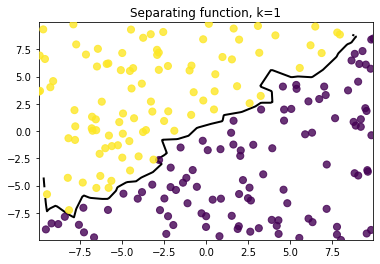

In [58]:
### Generate training and test sets, build and evaluate the KNN classifier

n = 200
D = 2

m = 0.9
q = 0.0

low_D = -10
high_D = 10

k = 1

# Generate a training set WITHOUT NOISE
Xtr, Ytr = linearBinaryClass(n, low_D, high_D, m, q)

# Visualize the separating curve for the NN classifier 
separatingFkNN(Xtr, Ytr, k)

# Generate a test set WITHOUT NOISE
Xte, Yte = linearBinaryClass(n, low_D, high_D, m, q)

# Evaluate the NN classifier on the TEST SET
Ypred = kNNClassify(Xtr, Ytr, k, Xte)

# Compute the error on the TEST SET
err = calcError(Ypred, Yte)

print("With K=%d the error on the test set is " % (k), err)

# How the classifier perform on the TRAINING SET instead?
Ypredtr = kNNClassify(Xtr, Ytr, k, Xtr)
errtr = calcError(Ypredtr, Ytr)
print("With K=%d the error on the training set is " % (k), errtr)


### Assignment 4: adding noise

Keeping the parameters of the function and the number of points as in the previous assignment:

- 1.Generate a training set WITH NOISE (for instance with 10% of flipped labels)
- 2.Visualize the separating curve for the **NN** classifier 
- 3.Generate a test set with the same amount of noise as the training set.
- 4.Evaluate the NN classifier on the TRAINING and on the TEST SET
- 5.Compute the obtained error on the TRAINING and on the TEST SET

- Repeat the steps from 1 to 5 with the **KNN** algorithm, setting for instance K=5

OBSERVE WHAT CHANGES...

In [59]:
def generateDataset(n=200, D=2, low_D=-10, high_D=10, m=0.9, q=0, noise=0):

    X, Y = linearBinaryClass(n, low_D, high_D, m, q)
    if noise > 0:
        Y = flipLabels(Y, noise)
    
    return X, Y

With K=5 the error on the test set is  0.115
With K=5 the error on the training set is  0.115


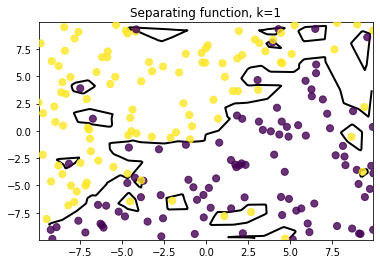

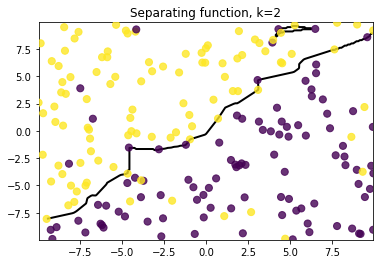

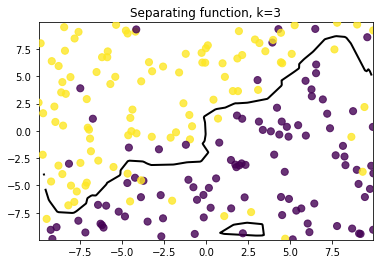

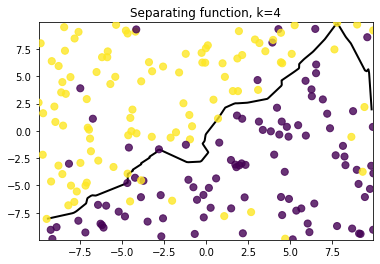

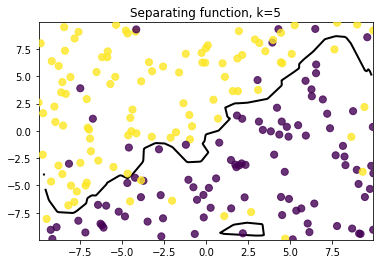

In [60]:
k=5


# Generate a training set WITH NOISE
Xtr, Ytr_n = generateDataset(n=200, m=0.9, q=0, noise=10)

for idx in range (1, k+1):
   
    # Visualize the separating curve for the NN classifier 
    separatingFkNN(Xtr, Ytr_n, idx)

# Generate a test set WITH NOISE
Xte, Yte_n = generateDataset(n=200, m=0.9, q=0, noise=10)

# Evaluate the NN classifier on the TEST SET
Ypred = kNNClassify(Xtr, Ytr_n, k, Xte)

# Compute the error on the TEST SET
err = calcError(Ypred, Yte_n)

print("With K={} the error on the test set is ".format(k), err)

# How the classifier perform on the TRAINING SET instead?
Ypredtr = kNNClassify(Xtr, Ytr_n, k, Xtr)
errtr = calcError(Ypredtr, Ytr_n)
print("With K={} the error on the training set is ".format(k), errtr)



Describe here what changes: 

1. With k = 0 there is total fitting of the data, we can see the what we may perceive as noise on the categorization problem is perfectly matched by the algorithm, leaving no space to accurate predictions on new data.
2. As we increase the number of neighbours, we can se how the noise becames increasingly ignored by the algorithm which gives back a more stable way to predict "future" data due to this flexibility and noise "tolerance"
3. when k is around 5 we can observe how the categories look well divided, the price we pay is that we cannot do a perfect estimate of new X values, but we can have an accuracy we would say "close" to the noise.

### Assignment 5

Analyse the performance of the **KNN** with plots, considering in particular the following:



- **SCENARIO 1**: Fix the number n of points to 200, fix the amount of noise to 10%, and plot the performance of the KNN classifier on TRAINING and TEST SETS as you increase the value of K

- **SCENARIO 2**: Fix the number n of points to 200, fix the value of K to a reasonable number of neighbours, and plot the performance of the KNN classifier on TRAINING and TEST SETS as you increase the amount of noise

- **SCENARIO 3**: Fix noise and K to two reasonable values, fix the number of TEST samples to 300, and plot the performance of the KNN classifier on TRAINING and TEST SETS as you increase the number of TRAINING samples (e.g. from 30 to 300 with steps 30)

- **SCENARIO 4**: Fix K and plot the performance of the KNN classifier on TRAINING and TEST SETS as you increase the amount of noise and the number of points

For each scenario, describe what happen

In [61]:
# kNN parameters
n = 200
D = 2
k_max = 40
neighbours = np.arange(1,k_max+1,5)
noise = 10
# setting up error arrays
err_Test  = np.empty(len(neighbours))
err_Train = np.empty(len(neighbours))
# Generate training set
Xtr, Ytr = generateDataset(n=n, noise = 10)
# Generate test set
Xte, Yte = generateDataset(n =n, noise = 10)
avg_err_Test =np.empty(len(neighbours))
avg_err_Train = np.empty(len(neighbours))
for i, k in enumerate(neighbours):
    # Compute the error on the TEST SET 
    err_Test[i]=( calcError(kNNClassify(Xtr, Ytr, k, Xte), Yte) )
    # Compute the error on the TRAINING SET 
    err_Train[i]=( calcError(kNNClassify(Xtr, Ytr, k, Xtr), Ytr) )
    

0.1675
0.136875


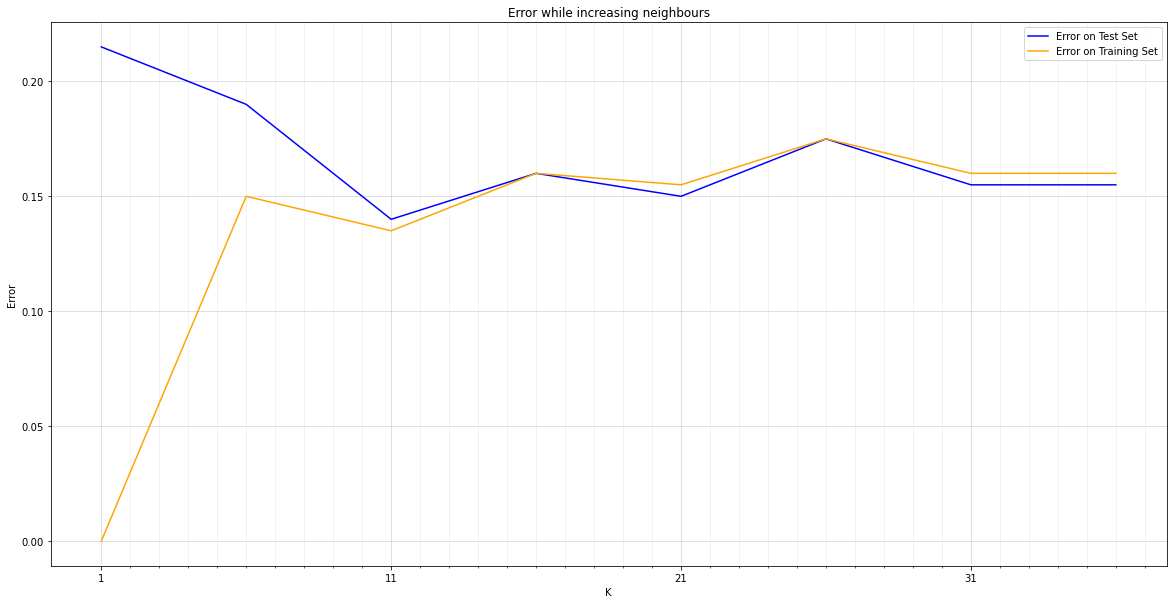

In [62]:

# grid scaling for plot
major_ticks = np.arange(1, k_max+1, 10 )
minor_ticks = np.arange(1, k_max+1, 1 )
# plot params
fig, ax = plt.subplots(1,figsize=(20, 10)) 
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)     
ax.set_xlabel('K')
ax.set_ylabel('Error')
ax.set_title('Error while increasing neighbours')
print(np.average(err_Test))
print(np.average(err_Train))
ax.plot(neighbours, err_Test, 'blue', label="Error on Test Set", )
ax.plot(neighbours, err_Train, 'orange', label="Error on Training Set")
ax.legend()
plt.show()


In [63]:
n = 200
D = 2
k = 10
maxNoise = 60
noise_list = np.arange(1, maxNoise+1,1)
err_list = []
errtr_list = []

# Generate a training set & test set
Xtr, Ytr = linearBinaryClass(n, low_D, high_D, m, q)
Xte, Yte = linearBinaryClass(n, low_D, high_D, m, q)
for noise in noise_list:
    #print(noise, end=' ')
    Ytr_n = flipLabels(Ytr, noise)
    # Evaluate the k-NN classifier on the TEST SET and compute the error
    Ypred = kNNClassify(Xtr, Ytr_n, k, Xte)
    err = calcError(Ypred, Yte)
    err_list.append(err)
    # Evaluate the K-NN classifier on the TRAINING SET and compute the error
    Ypredtr = kNNClassify(Xtr, Ytr_n, k, Xtr)
    errtr = calcError(Ypredtr, Ytr_n)
    errtr_list.append(errtr)

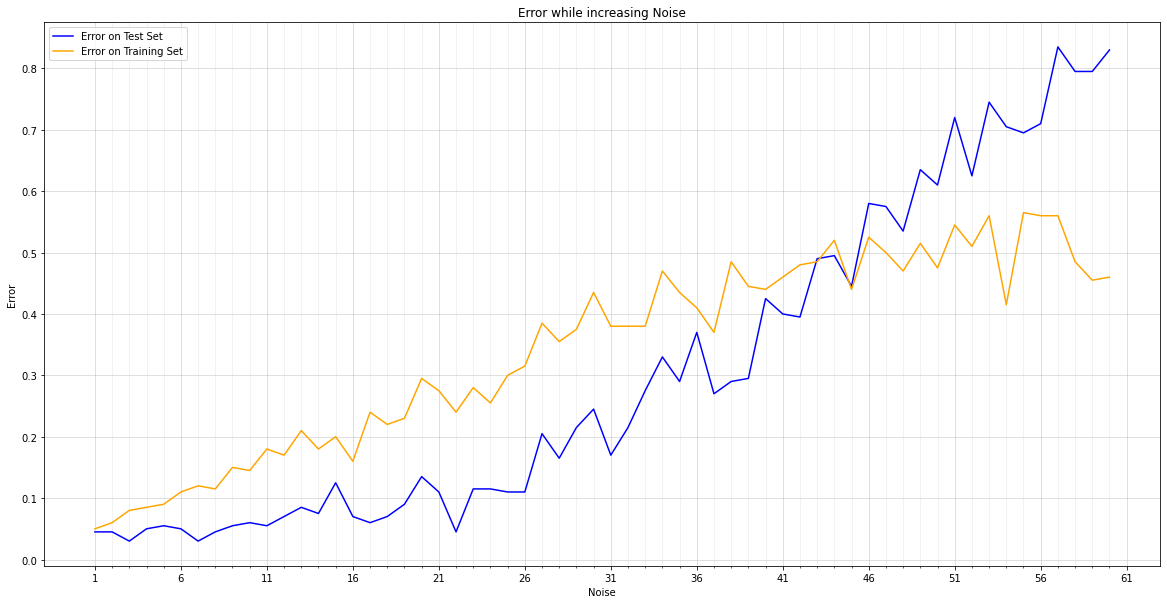

In [64]:
# grid scaling for plot
major_ticks = np.arange(1,  maxNoise+1+1, 5 )
minor_ticks = np.arange(1,  maxNoise+1+1, 1 )
# plot params
fig, ax = plt.subplots(1,figsize=(20, 10)) 
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)     
ax.set_xlabel('Noise')
ax.set_ylabel('Error')
ax.set_title('Error while increasing Noise')

ax.plot(noise_list, err_list, 'blue', label="Error on Test Set", )
ax.plot(noise_list, errtr_list, 'orange', label="Error on Training Set")
ax.legend()
plt.show()

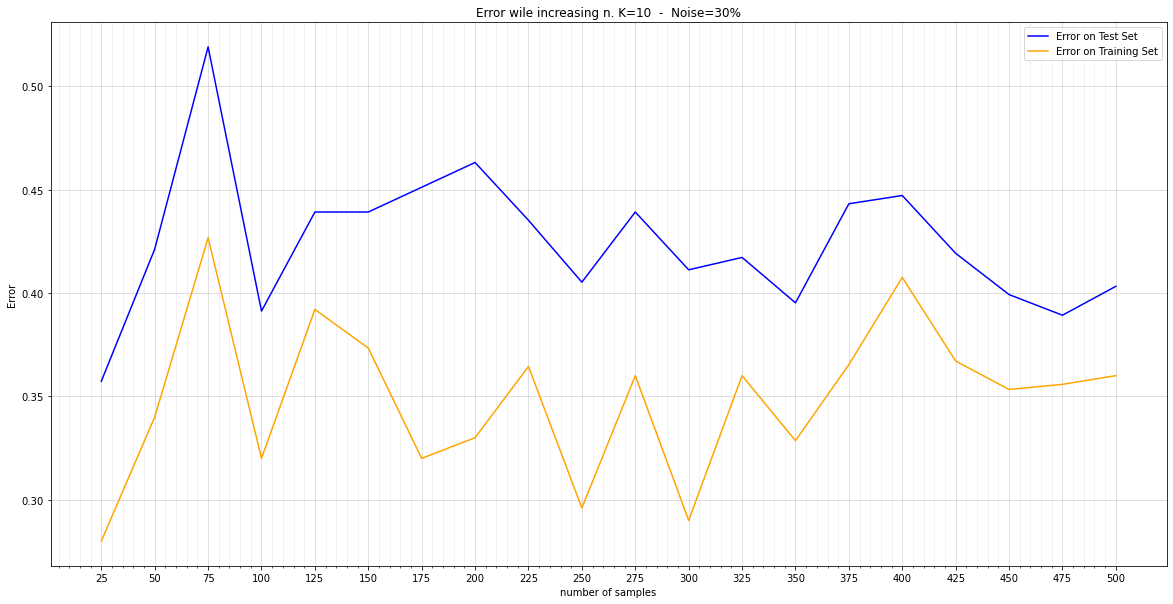

In [65]:
n_test = 500
D = 2
k = 10
noise = 30
err_list = []
errtr_list = []
train_Range = range(25,n_test+1, 25)
Xte, Yte = generateDataset(n=n_test+1, noise = noise)

for n in train_Range:
    
    Xtr, Ytr_n = generateDataset(n=n, noise = noise)
    # Evaluate the k-NN classifier on the TEST SET and compute the error
    err_list.append(calcError(kNNClassify(Xtr, Ytr_n, k, Xte), Yte))
    # Evaluate the K-NN classifier on the TRAINING SET and compute the error
    errtr_list.append(calcError(kNNClassify(Xtr, Ytr_n, k, Xtr), Ytr_n))
    

# grid scaling for plot
major_ticks = np.arange(25,  n_test+1, 25 )
minor_ticks = np.arange(0,  n_test+1, 5 )
# plot params
fig, ax = plt.subplots(1,figsize=(20, 10)) 
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)     
ax.set_xlabel('number of samples')
ax.set_ylabel('Error')
ax.set_title('Error wile increasing n. K={}  -  Noise={}%'.format(k,noise))
ax.plot(train_Range, err_list, 'blue', label="Error on Test Set", )
ax.plot(train_Range, errtr_list, 'orange', label="Error on Training Set")
ax.legend()
plt.show()

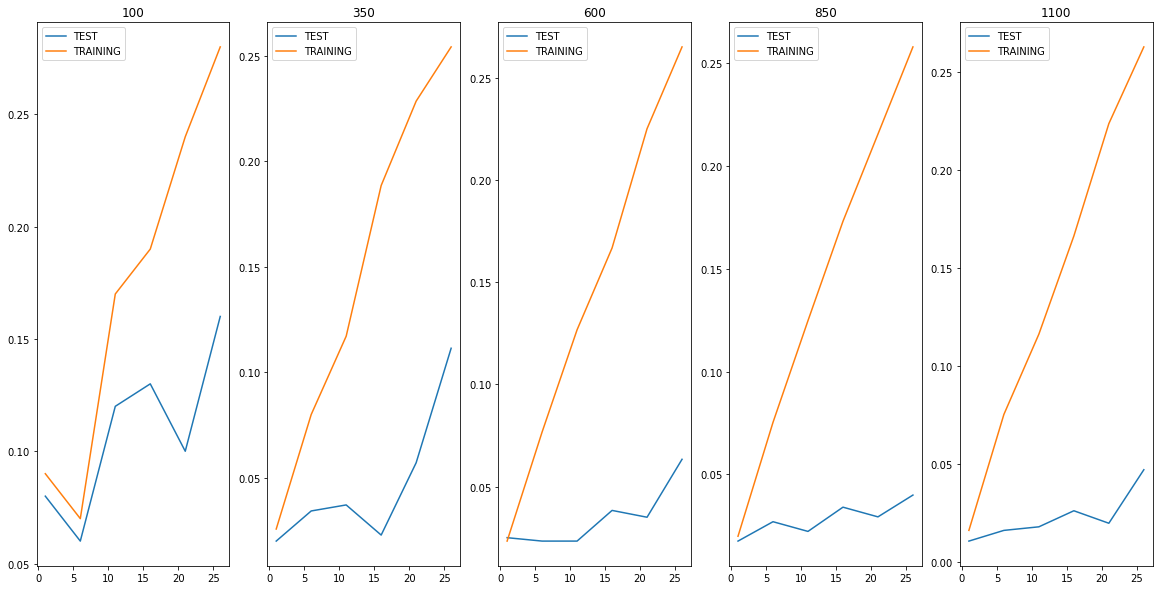

In [66]:
fig, axs = plt.subplots(1,5, figsize=(20,10))

D = 2
k = 15



# increasing noise intervals 
# not considering noise > 50 % 
noise_list = range(1, 30+1,5)

i = 0

#axs = axs.ravel()

for n in range(100, 1100+1, 250):
    err_list = []
    errtr_list = []
    for noise in noise_list :
      
        # Generate training set
        Xtr, Ytr = linearBinaryClass(n, low_D, high_D, m, q)
        Ytr_n = flipLabels(Ytr, noise)
        
        # Generate test set
        Xte, Yte = linearBinaryClass(n, low_D, high_D, m, q)

        # Evaluate the k-NN classifier on the TEST SET and compute the error
        Ypred = kNNClassify(Xtr, Ytr_n, k, Xte)
        err = calcError(Ypred, Yte)
        err_list.append(err)

        # Evaluate the K-NN classifier on the TRAINING SET and compute the error
        Ypredtr = kNNClassify(Xtr, Ytr_n, k, Xtr)
        errtr = calcError(Ypredtr, Ytr_n)
        errtr_list.append(errtr)
    
    axs[i].set_title( '{}'.format(n))
    axs[i].plot(noise_list, err_list, label="TEST")
    axs[i].plot(noise_list, errtr_list, label="TRAINING")
    axs[i].legend()
    i+=1


Insert here your observations:
- **SCENARIO 1**:
- **SCENARIO 2**:
- **SCENARIO 3**:
- **SCENARIO 4**:


# Scenario 1 
---


In scenario 1 as we increase the number of neighbours used in kNN algorithm whe can observe:

1. **With k = 1** we have 0 error on the training set. This does not work well on test set, where we have the maximum error of 22-23%, which is double of the noise. 

2. **As we increase** the number of neighbours we can observe that the algorithm performs better on the test set, having an error close to the noise of the input data (10%)    

# Scenario 2
---


In scenario 2 as we increase the noise  used in kNN algorithm with a fixed k = 10 whe can observe:


1. **As we increase** the noise we can see how the error grows in linear fashion in respect to it. It looks like the error is in some way, within some bounds "proportional" to the noise. 

2. When the noise is too high the error loose its meaning (unless the noise itself can be "cathegorized" in some way!) and of course the error in this setting the erron on the test set may grow faster than the one on the train set.

# Scenario 3
---


In scenario 3 as we increase the number of sample we can observe:


1. In this scenario it "looks like" (once k and noise is fixed) the error in the test set as we grow the number of samples in the training set, approaches the "noise" value: ss we increase the number of samples trom 25 to 500 with a step of 25 the error in both test and train sets (!) goes to some local minimum at some point with n in the range of [50, 100], after that the error grows rapidly to 45% and as we increase the number of samples it slowly decays somewhere close to the noise (around 30-35%)

2. The error in the training set is lower, but it follows the same trends

# Scenario 4

In scenario 4 we fixed k and we wanted to know what happends when we grow both n and noise. We Observed:

1. as we grow the number of samples looks like the classifier on the test set is less affected by the noise and more stable, up to when noise is around 45%, over that value the growth of error looks exponential.
2. the error on the train set grow linearly with the introduced noise, not depending in the number of samples
